# What is done?
### 1. Train baseline LightGBM model on 20 min forecasting
### 2. `HEATER` instead of `BANKA`

In [54]:
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import lightgbm as lgb
#import shap
import pickle

#shap.initjs()

from utils import *

In [55]:
# load data
forecast_period = 2
freq = '60s'
mode_col = 'HEATER'
data = pd.read_parquet('./data/dataset_featured_v1.parquet')
data = data.sort_values(by=['DATE']).reset_index(drop=True)
print('Shape: ', data.shape)
data.head(3)

Shape:  (1495, 110)


,HEATER,SMALL_LAMP,BIG_LAMP,EXT_T,TOP_T,MIDDLE_T,ENERGY_PULSES,ENERGY_WH,DATE,INDEX,...,TOP_T_median_6,TOP_T_min_6,TOP_T_max_6,MIDDLE_T_mean_6,MIDDLE_T_mean_decay_6,MIDDLE_T_median_6,MIDDLE_T_min_6,MIDDLE_T_max_6,HEATER_M1,HEATER_M0
0,3,0.0,0.0,0.12,51.04,46.46,42.6,7.0,2019-01-31 01:29:23,17,...,45.599998,43.459999,49.900002,42.183334,198.948364,41.570000,40.320000,44.900002,3,3
1,1,0.0,0.0,0.12,51.62,46.94,41.8,6.8,2019-01-31 01:34:23,18,...,46.660000,44.939999,50.320000,43.063332,203.225830,42.740002,41.099998,45.599998,3,1
2,2,0.0,0.0,0.22,51.44,47.04,33.8,5.4,2019-01-31 01:39:23,19,...,48.549999,44.939999,51.040001,43.956665,207.521027,44.270000,41.299999,46.459999,1,2


In [56]:
assert data['DATE'].unique().shape[0] == data.shape[0]

In [57]:
val_size = 12 * 12 # 2 hours
test_size = 12 * 12 # 

data_trainval = data.iloc[:-test_size].copy()

data_train = data.iloc[:-(val_size + test_size)].copy()
data_val = data.iloc[-(val_size + test_size): -test_size].copy()
data_test = data.iloc[-test_size:].copy()

del data

In [58]:
future_cols = ['HEATER_M' + str(i) for i in range(forecast_period)]
future_cols.extend(['INDEX', 'EXT_T', 'MIDDLE_T', 'TOP_T', 'DATE', 'HEATER_M'])

features = [s for s in data_train.columns if s not in future_cols]
target_label = ['MIDDLE_T']

In [59]:
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [107]:
dts = lgb.Dataset(data_train[features], label=data_train[target_label])
dts = dts.construct()
dtsv = dts.create_valid(data_val[features], label=data_val[target_label])

In [158]:
params = {
    'application': 'regression_l2',
    'learning_rate': 0.04,
    'reg_alpha': 1e-3,
    #'min_data_in_leaf': 3,
    'num_leaves': 9,
    'metric': 'l2'
}

In [159]:
bst = lgb.train(params, dts, valid_sets = [dtsv], valid_names = ['Validation'],
                num_boost_round = 10000, early_stopping_rounds = 10)

[1]	Validation's l2: 20.9979
Training until validation scores don't improve for 10 rounds.
[2]	Validation's l2: 19.7713
[3]	Validation's l2: 18.671
[4]	Validation's l2: 17.588
[5]	Validation's l2: 16.6261
[6]	Validation's l2: 15.7394
[7]	Validation's l2: 14.8696
[8]	Validation's l2: 14.0557
[9]	Validation's l2: 13.2992
[10]	Validation's l2: 12.6386
[11]	Validation's l2: 11.975
[12]	Validation's l2: 11.3676
[13]	Validation's l2: 10.8101
[14]	Validation's l2: 10.2759
[15]	Validation's l2: 9.78235
[16]	Validation's l2: 9.33586
[17]	Validation's l2: 8.89688
[18]	Validation's l2: 8.47514
[19]	Validation's l2: 8.09577
[20]	Validation's l2: 7.72734
[21]	Validation's l2: 7.40371
[22]	Validation's l2: 7.09204
[23]	Validation's l2: 6.79572
[24]	Validation's l2: 6.51653
[25]	Validation's l2: 6.24537
[26]	Validation's l2: 6.00212
[27]	Validation's l2: 5.78064
[28]	Validation's l2: 5.54347
[29]	Validation's l2: 5.33109
[30]	Validation's l2: 5.13431
[31]	Validation's l2: 4.94551
[32]	Validation's l2

In [160]:
# save(bst, './saved_models/3min/lgbm_3min_v1.pkl')

In [161]:
y_test = bst.predict(data_test[features])
y_val = bst.predict(data_val[features])
y_train = bst.predict(data_train[features])

In [65]:
#print('CV score: %.3f' % grid_lgb.best_score_)
print('MAE on train: %.3f' % mean_absolute_error(data_train[target_label].values, y_train))
print('MAE on val: %.3f' % mean_absolute_error(data_val[target_label].values, y_val))
print('MAE on test: %.3f' % mean_absolute_error(data_test[target_label].values, y_test))
print()
print('RMSE on train: %.2f' % np.sqrt(mean_squared_error(data_train[target_label].values, y_train)))
print('RMSE on val: %.2f' % np.sqrt(mean_squared_error(data_val[target_label].values, y_val)))
print('RMSE on test: %.2f' % np.sqrt(mean_squared_error(data_test[target_label].values, y_test)))

MAE on train: 0.420
MAE on val: 0.769
MAE on test: 0.567

RMSE on train: 0.53
RMSE on val: 0.99
RMSE on test: 0.72


In [162]:
#print('CV score: %.3f' % grid_lgb.best_score_)
print('MAE on train: %.3f' % mean_absolute_error(data_train[target_label].values, y_train))
print('MAE on val: %.3f' % mean_absolute_error(data_val[target_label].values, y_val))
print('MAE on test: %.3f' % mean_absolute_error(data_test[target_label].values, y_test))
print()
print('RMSE on train: %.2f' % np.sqrt(mean_squared_error(data_train[target_label].values, y_train)))
print('RMSE on val: %.2f' % np.sqrt(mean_squared_error(data_val[target_label].values, y_val)))
print('RMSE on test: %.2f' % np.sqrt(mean_squared_error(data_test[target_label].values, y_test)))

MAE on train: 0.371
MAE on val: 0.749
MAE on test: 0.566

RMSE on train: 0.47
RMSE on val: 0.95
RMSE on test: 0.72


In [163]:
dts = lgb.Dataset(data_trainval[features], label=data_trainval[target_label])
dts = dts.construct()
dtst = dts.create_valid(data_test[features], label=data_test[target_label])

In [164]:
bst = lgb.train(params, dts, valid_sets = [dtst], valid_names = ['Test'],
                num_boost_round=bst.best_iteration, early_stopping_rounds=10)

[1]	Test's l2: 13.7732
Training until validation scores don't improve for 10 rounds.
[2]	Test's l2: 12.8632
[3]	Test's l2: 12.0078
[4]	Test's l2: 11.1925
[5]	Test's l2: 10.4819
[6]	Test's l2: 9.81884
[7]	Test's l2: 9.20187
[8]	Test's l2: 8.63151
[9]	Test's l2: 8.09917
[10]	Test's l2: 7.62056
[11]	Test's l2: 7.16818
[12]	Test's l2: 6.7509
[13]	Test's l2: 6.36448
[14]	Test's l2: 5.99123
[15]	Test's l2: 5.65547
[16]	Test's l2: 5.33514
[17]	Test's l2: 5.05163
[18]	Test's l2: 4.78047
[19]	Test's l2: 4.5199
[20]	Test's l2: 4.28887
[21]	Test's l2: 4.07863
[22]	Test's l2: 3.86772
[23]	Test's l2: 3.67404
[24]	Test's l2: 3.49737
[25]	Test's l2: 3.33071
[26]	Test's l2: 3.1931
[27]	Test's l2: 3.04638
[28]	Test's l2: 2.91335
[29]	Test's l2: 2.79399
[30]	Test's l2: 2.66949
[31]	Test's l2: 2.5899
[32]	Test's l2: 2.48232
[33]	Test's l2: 2.39233
[34]	Test's l2: 2.29213
[35]	Test's l2: 2.20345
[36]	Test's l2: 2.12115
[37]	Test's l2: 2.02663
[38]	Test's l2: 1.96869
[39]	Test's l2: 1.91513
[40]	Test's l2:

In [165]:
y_trainval = bst.predict(data_trainval[features].values)
y_test = bst.predict(data_test[features].values)

In [166]:
#print('CV score: %.3f' % grid_lgb.best_score_)
print('MAE on trainval: %.3f' % mean_absolute_error(data_train[target_label].values, y_train))
print('MAE on test: %.3f' % mean_absolute_error(data_test[target_label].values, y_test))
print()
print('RMSE on trainval: %.2f' % np.sqrt(mean_squared_error(data_train[target_label].values, y_train)))
print('RMSE on test: %.2f' % np.sqrt(mean_squared_error(data_test[target_label].values, y_test)))

MAE on trainval: 0.371
MAE on test: 0.552

RMSE on trainval: 0.47
RMSE on test: 0.71


In [94]:
row = data_test.iloc[15:16].copy()

In [95]:
row['HEATER_M2']

1366    2
Name: HEATER_M2, dtype: int8

In [101]:
row['HEATER_M3']

1366    5
Name: HEATER_M3, dtype: int8

In [104]:
row['HEATER_M3'] = 5

In [96]:
row['HEATER_M2'] = 5

In [99]:
bst.predict(data_test.iloc[15:16][features])

array([47.94116072])

In [103]:
bst.predict(row[features])

array([47.25384212])

In [82]:
row = data_test.iloc[15]

In [84]:
bst.predict(data_test.iloc[15:16][features])

array([47.94116072])

In [167]:
sc = bst.feature_importance(importance_type = 'gain')
score = pd.DataFrame(100 * sc / np.sum(sc),
                     index = bst.feature_name(), columns = ['Score'])

In [168]:
score = score.sort_values('Score', ascending=False)

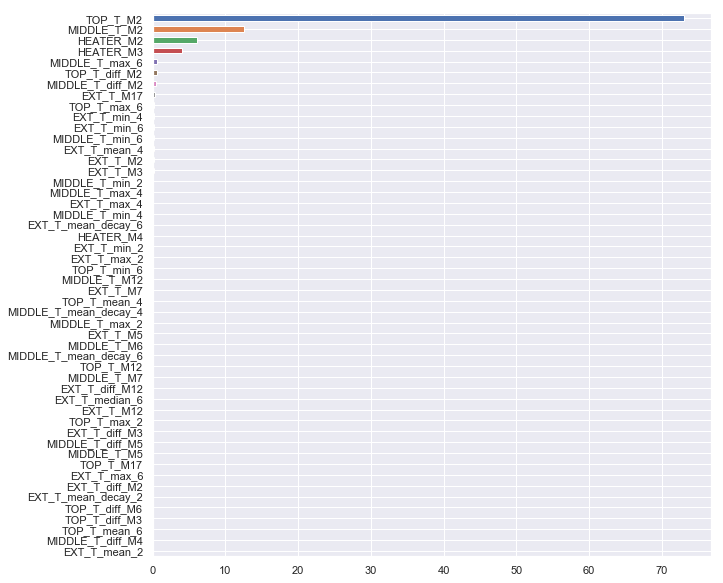

In [169]:
score.head(50).Score.plot.barh(grid=True, figsize=(10,10)).invert_yaxis()

In [170]:
res = data_test[['DATE', 'MIDDLE_T', 'HEATER']].copy()
res['PRED'] = y_test

In [171]:
def plot_pred(results):
    plt.figure(figsize=(18,10))
    plt.title('Timeseries plot')
    plt.plot(results['DATE'], results['MIDDLE_T'], c='green', ls='-', lw=1, label='$MIDDLE_T$')
    plt.plot(results['DATE'], results['PRED'], 'r-.', lw=1, label='$\hat{MIDDLE_T}$ pred')
    #plt.plot(results['DATE'], results[mode_col] * max(results['MIDDLE_T']), 'c-', lw=0.5, label='$HEATER$')
    plt.xlabel('Datetime')
    plt.ylim((0, 60))
    plt.legend(loc='best')
    plt.show()

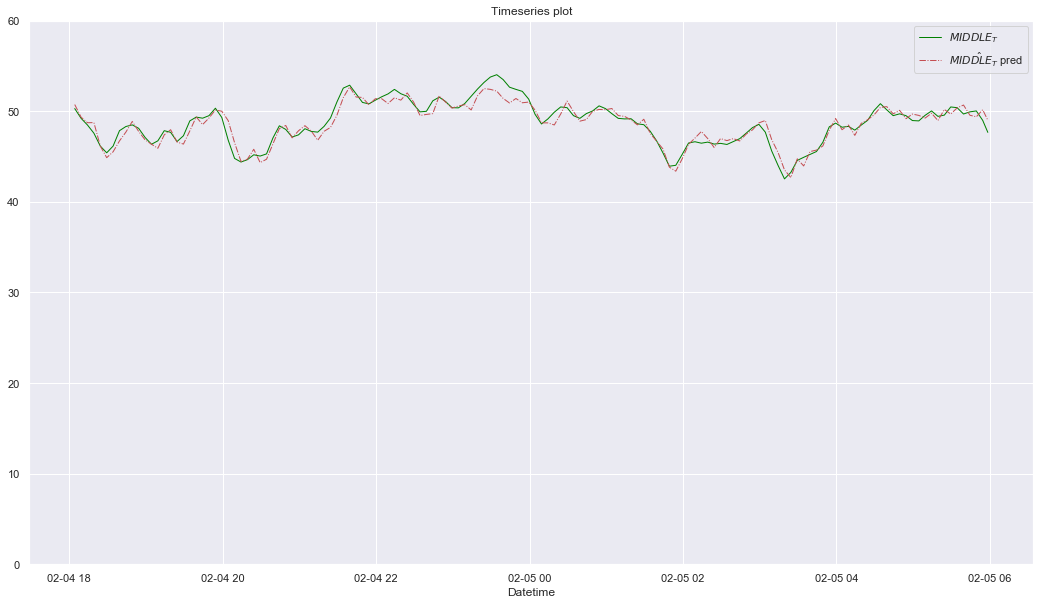

In [172]:
plot_pred(res)

In [173]:
from sklearn.metrics import r2_score

In [174]:
r2_score(data_test[target_label], y_test)

0.9078706184200325

In [177]:
data_train.EXT_T.std()

2.204765317065707